In [5]:

# === Setup & Imports ===
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Config
OUTDIR = Path("outputs")
OUTDIR.mkdir(exist_ok=True)
RANDOM_STATE = 42
SHOW_PLOTS = True  # In notebooks, default to True so plots display inline

print("Working directory:", os.getcwd())


Working directory: C:\Users\mryuf


In [6]:

# === Set your DATA_PATH and load the dataset ===
# Option A: If train.csv is in the same folder as this notebook:
DATA_PATH = "train.csv"

# Option B: Use absolute Windows path (example)
# DATA_PATH = r"D:\Training\MIT\Data Science\Assignments-20250728\Assignment 2\train.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Could not find file at {DATA_PATH!r}.\n"
        "Fix by either:\n"
        "  1) placing train.csv next to this notebook and keeping DATA_PATH = 'train.csv', OR\n"
        "  2) setting DATA_PATH = r'Full\\Absolute\\Path\\to\\train.csv'"
    )

df = pd.read_csv(DATA_PATH)
print("[INFO] Shape:", df.shape)
display(df.head(3))


[INFO] Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [7]:

# === Helper functions for EDA & plotting ===
def save_scatter(x, y, xlabel, ylabel, title, outfile):
    plt.figure()
    plt.scatter(x, y, alpha=0.6)
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    plt.tight_layout()
    plt.savefig(OUTDIR / outfile)
    if SHOW_PLOTS: plt.show()
    plt.close()

def save_corr_heatmap_top(df, target, topN=16):
    num_df = df.select_dtypes(include=["number"]).copy()
    corr_full = num_df.corr(numeric_only=True)
    target_corr = corr_full[target].abs().sort_values(ascending=False)
    feats = target_corr.index[:topN]
    corr_top = corr_full.loc[feats, feats]

    plt.figure(figsize=(8, 6))
    im = plt.imshow(corr_top, cmap="viridis")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f"Correlation Heatmap (Top features w.r.t. {target})")
    plt.xticks(range(len(feats)), feats, rotation=90)
    plt.yticks(range(len(feats)), feats)
    plt.tight_layout()
    plt.savefig(OUTDIR / "corr_heatmap_top.png")
    if SHOW_PLOTS: plt.show()
    plt.close()

def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name:>16}  MAE={mae:,.0f}  RMSE={rmse:,.0f}  R²={r2:.3f}")
    return {"model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

def save_actual_vs_pred(y_true, y_pred, title, outfile):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.6)
    m1, m2 = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([m1, m2], [m1, m2])
    plt.xlabel("Actual SalePrice"); plt.ylabel("Predicted SalePrice"); plt.title(title)
    plt.tight_layout()
    plt.savefig(OUTDIR / outfile)
    if SHOW_PLOTS: plt.show()
    plt.close()

def get_feature_names_from_preprocessor(fitted_preprocessor, num_names, cat_names):
    # OneHotEncoder feature names
    ohe = fitted_preprocessor.named_transformers_["cat"].named_steps["ohe"]
    try:
        cat_ohe_names = ohe.get_feature_names_out(cat_names)
    except AttributeError:
        cat_ohe_names = ohe.get_feature_names(cat_names)
    all_names = list(num_names) + list(cat_ohe_names)
    return all_names

def save_feature_importance(model_pipeline, num_cols, cat_cols, title, outfile, top_n=20):
    fitted_pre = model_pipeline.named_steps["pre"]
    names = get_feature_names_from_preprocessor(fitted_pre, num_cols, cat_cols)
    model = model_pipeline.named_steps["model"]
    if not hasattr(model, "feature_importances_"):
        return
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1][:top_n]
    top_imp = importances[idx]
    top_names = [names[i] for i in idx]

    plt.figure(figsize=(8, max(4, int(len(top_names)*0.4))))
    plt.barh(range(len(top_names)), top_imp[::-1])
    plt.yticks(range(len(top_names)), top_names[::-1])
    plt.title(title)
    plt.tight_layout()
    plt.savefig(OUTDIR / outfile)
    if SHOW_PLOTS: plt.show()
    plt.close()



[DESCRIBE]



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1460.0,NaN,NaN,NaN,730.5,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,NaN,NaN,NaN,56.89726,42.300571,20.0,20.0,50.0,70.0,190.0
MSZoning,1460,5,RL,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1201.0,NaN,NaN,NaN,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0
LotArea,1460.0,NaN,NaN,NaN,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.5,215245.0
Street,1460,2,Pave,1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alley,91,2,Grvl,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotShape,1460,4,Reg,925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LandContour,1460,4,Lvl,1311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Utilities,1460,2,AllPub,1459,NaN,NaN,NaN,NaN,NaN,NaN,NaN



[MISSING (top 15)]



PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
dtype: int64

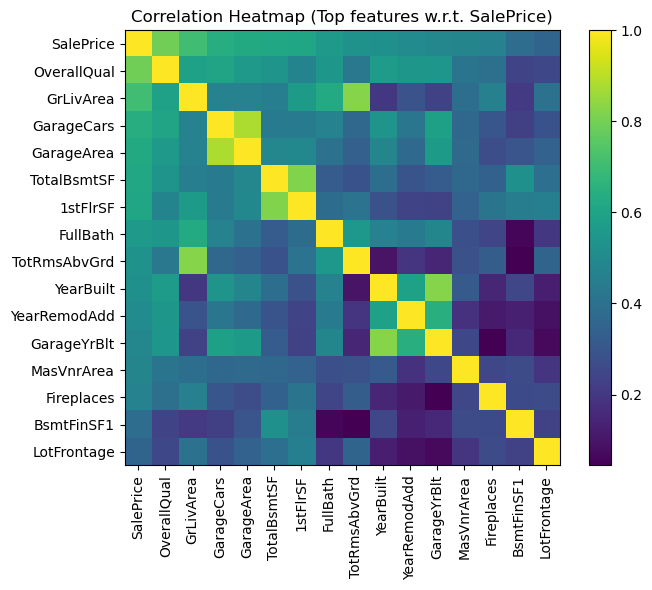

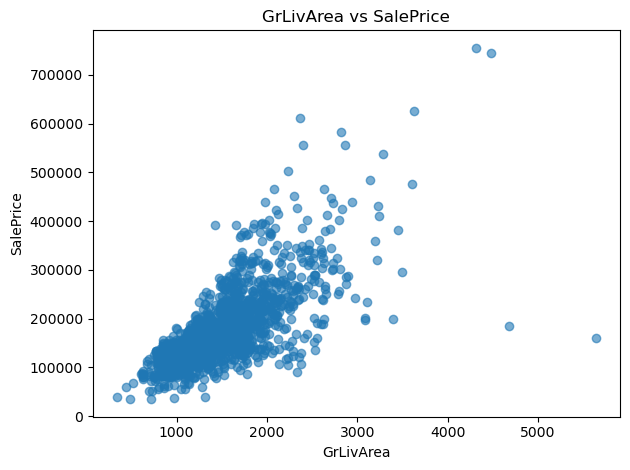

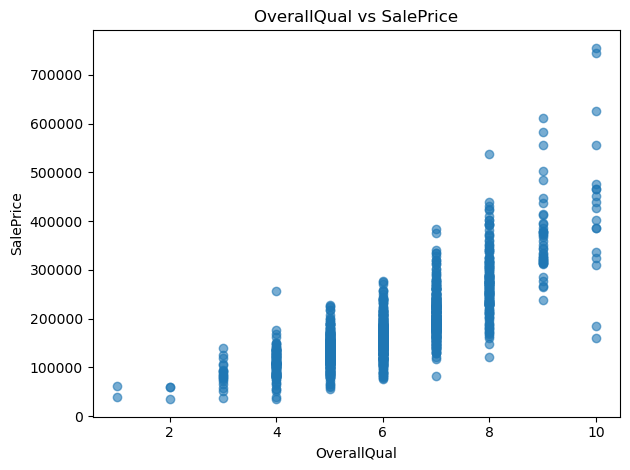

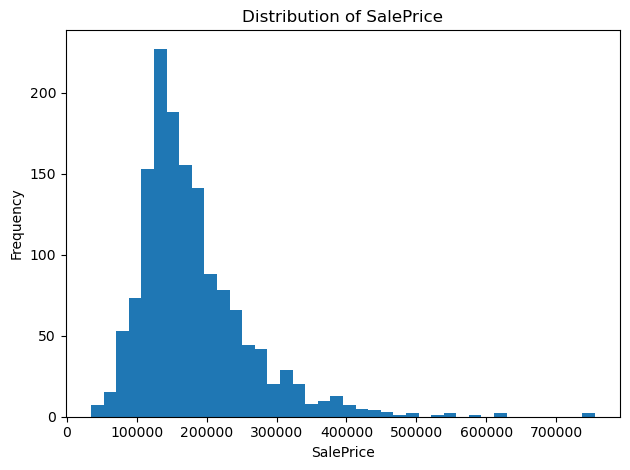

In [8]:

# === Basic EDA ===
print("\n[DESCRIBE]\n")
display(df.describe(include='all').T.head(15))

na = df.isna().sum().sort_values(ascending=False)
print("\n[MISSING (top 15)]\n")
display(na.head(15))

# Correlations & a few bivariate plots
save_corr_heatmap_top(df, target="SalePrice", topN=16)

if "GrLivArea" in df.columns:
    save_scatter(df["GrLivArea"], df["SalePrice"], "GrLivArea", "SalePrice",
                 "GrLivArea vs SalePrice", "fig_grlivarea_vs_saleprice.png")
if "OverallQual" in df.columns:
    save_scatter(df["OverallQual"], df["SalePrice"], "OverallQual", "SalePrice",
                 "OverallQual vs SalePrice", "fig_overallqual_vs_saleprice.png")

plt.figure()
plt.hist(df["SalePrice"].dropna(), bins=40)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice"); plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(OUTDIR / "fig_saleprice_hist.png")
if SHOW_PLOTS: plt.show()
plt.close()


In [10]:

# === Split & ColumnTransformer ===
y = df["SalePrice"].astype(float)
X = df.drop(columns=["SalePrice", "Id"], errors="ignore")
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

num_tf = Pipeline([("imp", SimpleImputer(strategy="median")),
                   ("sc", StandardScaler())])
cat_tf = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                   ("ohe", OneHotEncoder(handle_unknown="ignore"))])

pre = ColumnTransformer([("num", num_tf, num_cols),
                         ("cat", cat_tf, cat_cols)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

len(num_cols), len(cat_cols), X_train.shape, X_test.shape


(36, 43, (1168, 79), (292, 79))

LinearRegression  MAE=18,288  RMSE=29,474  R²=0.887


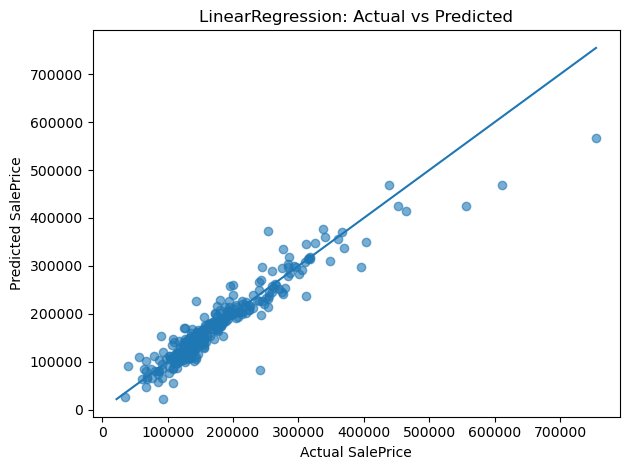

[CV R²] LinearRegression mean=0.770 ± 0.083
           Ridge  MAE=19,041  RMSE=30,646  R²=0.878


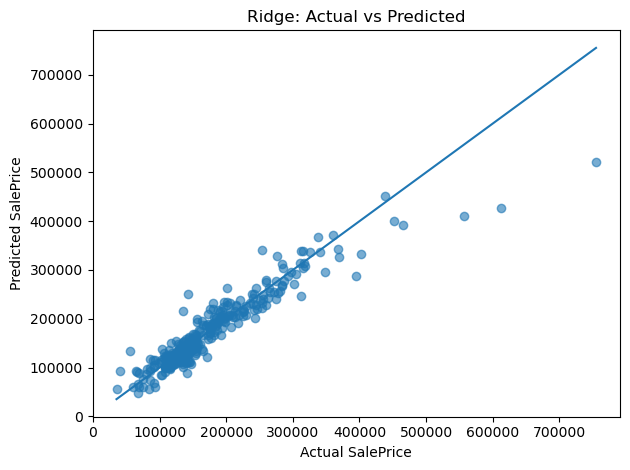

[CV R²] Ridge            mean=0.829 ± 0.068
           Lasso  MAE=18,020  RMSE=28,370  R²=0.895


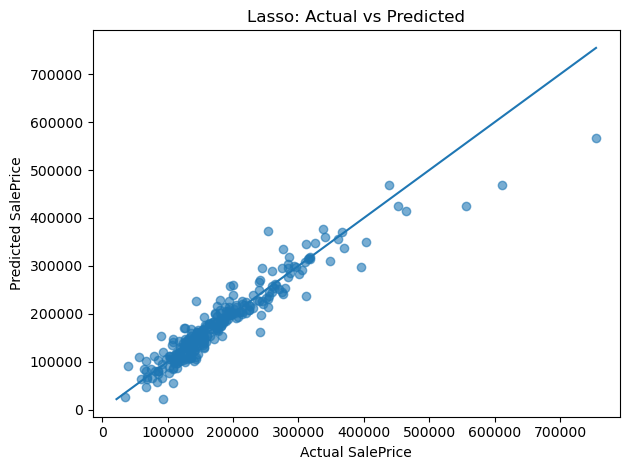

[CV R²] Lasso            mean=0.773 ± 0.080
    RandomForest  MAE=17,360  RMSE=28,398  R²=0.895


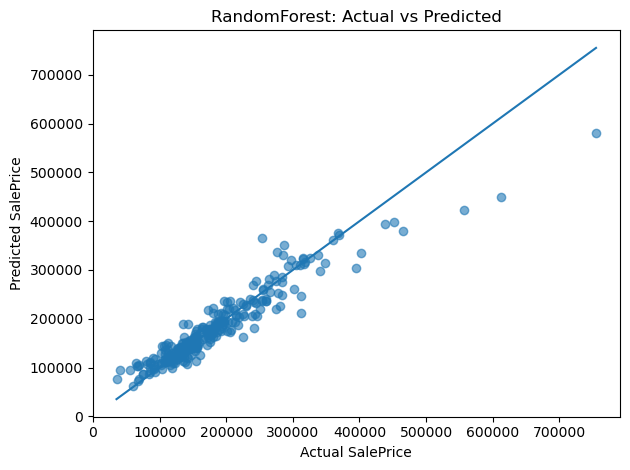

[CV R²] RandomForest     mean=0.844 ± 0.042
GradientBoosting  MAE=16,556  RMSE=26,504  R²=0.908


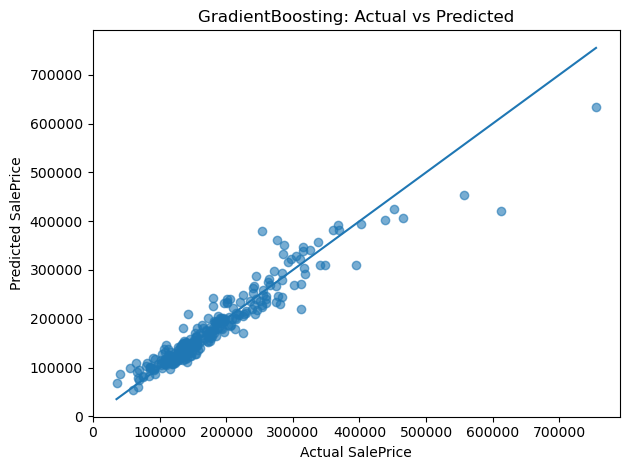

[CV R²] GradientBoosting mean=0.867 ± 0.054


,model,MAE,RMSE,R2
4,GradientBoosting,16555.666542,26503.771884,0.908420
2,Lasso,18019.985261,28370.273540,0.895067
3,RandomForest,17360.377728,28398.152813,0.894860
0,LinearRegression,18288.287620,29473.733570,0.886745
1,Ridge,19040.553499,30646.148096,0.877556



[Saved metrics] outputs\model_results.csv


In [12]:

# === Models & Training Loop ===
# models = {
#     "LinearRegression": LinearRegression(),
#     "Ridge": Ridge(alpha=10.0),
#     "Lasso": Lasso(alpha=0.0005, max_iter=10000),
#     "RandomForest": RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE),
#     "GradientBoosting": GradientBoostingRegressor(random_state=RANDOM_STATE)
# }

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=10.0, random_state=RANDOM_STATE),
    'Lasso': Lasso(alpha=0.05, max_iter=200000, tol=1e-2, random_state=RANDOM_STATE),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
}

results = []
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
fitted_pipelines = {}

for name, est in models.items():
    pipe = Pipeline([("pre", pre), ("model", est)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    res = evaluate(y_test, y_pred, name)
    results.append(res)
    fitted_pipelines[name] = pipe

    # Save Actual vs Pred for each model
    save_actual_vs_pred(y_test, y_pred, f"{name}: Actual vs Predicted",
                        f"fig_{name.lower()}_actual_vs_pred.png")

    # CV stability check on train only (R2)
    cv_r2 = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="r2")
    print(f"[CV R²] {name:16} mean={cv_r2.mean():.3f} ± {cv_r2.std():.3f}")

results_df = pd.DataFrame(results).sort_values(by="RMSE")
display(results_df)
csv_path = OUTDIR / "model_results.csv"
results_df.to_csv(csv_path, index=False)
print("\n[Saved metrics]", csv_path)


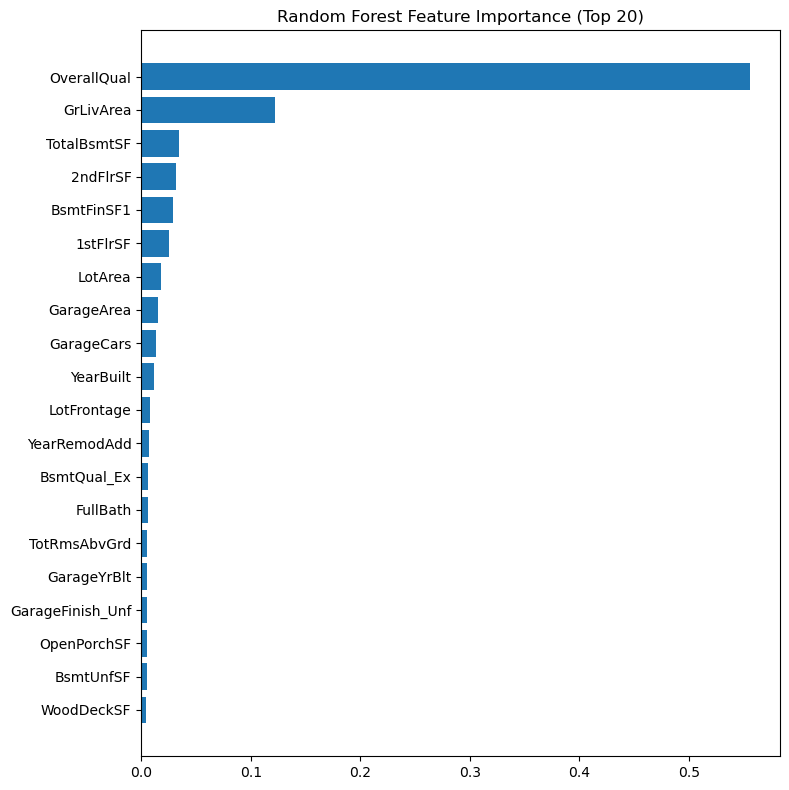

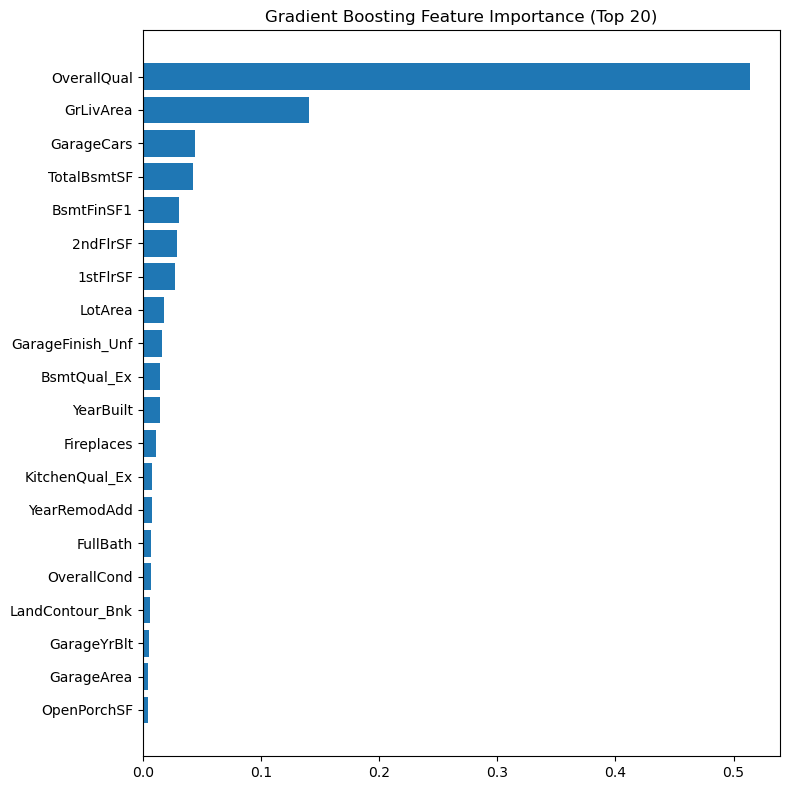


[Saved figures] in C:\Users\mryuf\outputs
 - corr_heatmap_top.png
 - fig_gradientboosting_actual_vs_pred.png
 - fig_gradientboosting_feature_importance.png
 - fig_grlivarea_vs_saleprice.png
 - fig_lasso_actual_vs_pred.png
 - fig_linearregression_actual_vs_pred.png
 - fig_overallqual_vs_saleprice.png
 - fig_randomforest_actual_vs_pred.png
 - fig_randomforest_feature_importance.png
 - fig_ridge_actual_vs_pred.png
 - fig_saleprice_hist.png


In [13]:

# === Feature importances (tree models) ===
if "RandomForest" in fitted_pipelines:
    save_feature_importance(
        fitted_pipelines["RandomForest"], num_cols, cat_cols,
        "Random Forest Feature Importance (Top 20)",
        "fig_randomforest_feature_importance.png", top_n=20
    )

if "GradientBoosting" in fitted_pipelines:
    save_feature_importance(
        fitted_pipelines["GradientBoosting"], num_cols, cat_cols,
        "Gradient Boosting Feature Importance (Top 20)",
        "fig_gradientboosting_feature_importance.png", top_n=20
    )

print("\n[Saved figures] in", OUTDIR.resolve())
for p in OUTDIR.glob("*.png"):
    print(" -", p.name)
